# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation.

This notebook and train.py script in source folder were derived from [spleen_segmentation_3d notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

### install and import monai libraries 

In [406]:
!pip install  "monai[all]==0.8.0"

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [407]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [408]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import math
from pathlib import Path
import sagemaker 
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch


role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose from MONAI
+ Visualize the image 

In [409]:
# Download the images
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"
data_dir = "Spleen3D" 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir+'/datasets', md5)

In [410]:
## transform the images through Compose
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


In [411]:
## divide the images into training and testing dataset
train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-1], data_dicts[-1:]

image shape: torch.Size([233, 209, 101]), label shape: torch.Size([233, 209, 101])


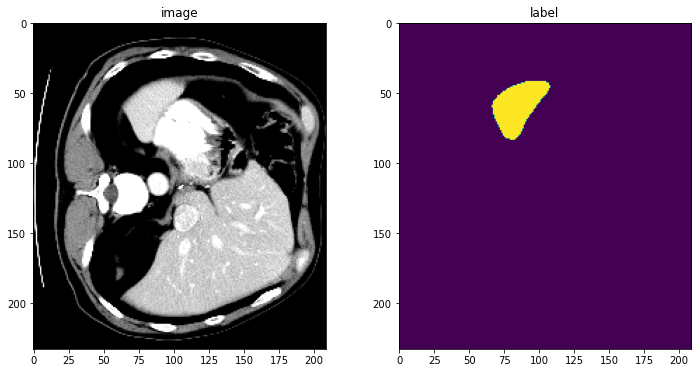

In [412]:
# Visualization
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot only the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Divide the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [413]:
processed_train_path = os.path.join(data_dir,"processed","train")
processed_test_path = os.path.join(data_dir,"processed","test")

processed_train_images_path = os.path.join(processed_train_path, "imagesTr")
processed_train_labels_path = os.path.join(processed_train_path, "labelsTr")

processed_test_images_path = os.path.join(processed_test_path, "imagesTr")
processed_test_labels_path = os.path.join(processed_test_path, "labelsTr")

Path(processed_train_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_train_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_train_path)

Path(processed_test_images_path).mkdir(parents=True, exist_ok=True)
Path(processed_test_labels_path).mkdir(parents=True, exist_ok=True)
print("Directory '%s' created" %processed_test_path)

Directory 'Spleen3D/processed/train' created
Directory 'Spleen3D/processed/test' created


In [414]:
## copy dataset for training 
for file in train_files:
    image = file['image']
    image_dest = processed_train_images_path
    label = file['label']
    label_dest = processed_train_labels_path
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [415]:
## copy dataset for testing  
for file in val_files:
    image = file['image']
    image_dest = processed_test_images_path
    label = file['label']
    label_dest = processed_test_labels_path
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [416]:
## upload the dataset to S3
prefix="MONAI_Segmentation"
## upload training dataset
S3_inputs = sess.upload_data(
    path=processed_train_path,
    key_prefix=prefix+"/train",
    bucket=bucket 
)

## upload testing dataset
S3_test = sess.upload_data(
    path=processed_test_path,
    key_prefix=prefix+"/test",
    bucket=bucket 
)


### SageMaker training job

In [417]:
%time

metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]

estimator = PyTorch(source_dir='code',
                    entry_point='train.py',
                    role=role,
                    framework_version='1.6.0',
                    py_version='py3',
                    instance_count=1,
#                     instance_type='ml.p2.xlarge',
                    instance_type='ml.p3.2xlarge',
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 200
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
2022-04-24 20:52:54 Starting - Starting the training job...
2022-04-24 20:53:19 Starting - Preparing the instances for trainingProfilerReport-1650833573: InProgress
.........
2022-04-24 20:54:37 Downloading - Downloading input data...
2022-04-24 20:55:17 Training - Downloading the training image............
2022-04-24 20:57:17 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-24 20:57:17,124 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-24 20:57:17,150 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-24 20:57:17,159 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-24 20:57:17,616 sagemaker-training-toolkit INFO     Installing dependencies from requir

In [418]:
model_data=estimator.latest_training_job.describe()["ModelArtifacts"]["S3ModelArtifacts"]

## Inference 

+ deploy the model with customized inference script
+ inference with testing image in S3
+ visualization the results

In [419]:
%time

from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    entry_point="inference.py", ## inference code with customization
    source_dir="code",        ## folder with the inference code
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)

predictor = model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.m5.2xlarge',
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer()
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
-------!

In [420]:
%timeit
mode = "val"
step = 1
val_preds=[]
for counter in range(math.ceil(len(val_files)/step)):
    payload={
        "bucket": bucket,
        "key": prefix+"/test",
        "start": counter,
        "step": step,
        "mode": mode
            }
    response_val=predictor.predict(payload)
    val_preds.append(response_val)

## Visualize the result

In [421]:
val_predictions = val_preds[0]["pred"]
torch.tensor(val_predictions[0]).shape

torch.Size([233, 209])

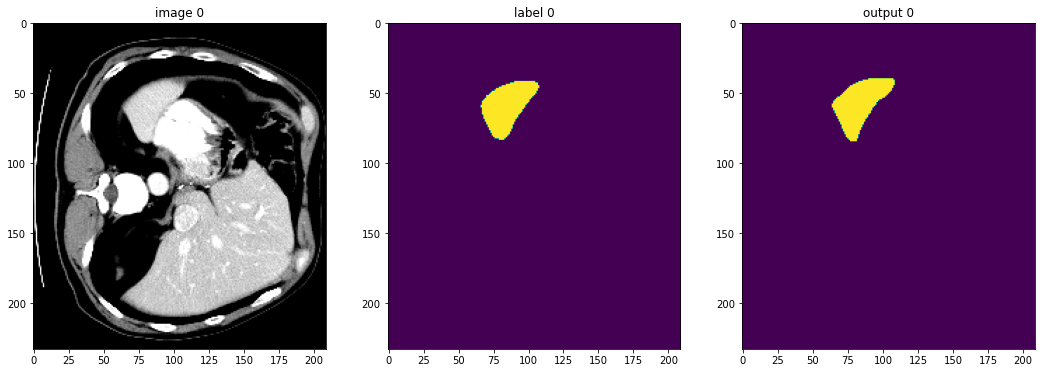

In [422]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualization
val_ds = check_ds
val_loader = check_loader
val_data = check_loader
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(val_predictions[i])

        plt.show()

## Test Data

In [423]:
img_test_path = os.path.join(data_dir, "datasets/Task09_Spleen/imagesTs")
test_images = sorted(glob.glob(os.path.join(img_test_path, "*.nii.gz")))

In [424]:
## upload testing dataset
S3_test = sess.upload_data(
    path=img_test_path,
    key_prefix=prefix+"/img_test/imagesTs",
    bucket=bucket 
)

In [425]:
# inference
predictions = []
mode = "test"
step = 1
end = 5
test_images_list=test_images[:end]
for counter in range(math.ceil(len(test_images_list)/step)):
    payload={
        "bucket": bucket,
        "key": prefix+"/img_test",
        "start": counter,
        "step": step,
        "mode": mode
            }
    response_test=predictor.predict(payload)
    print(counter,"pred")
    predictions.append(response_test)

0 pred
1 pred
2 pred
3 pred
4 pred


In [426]:
torch.tensor(predictions[0]["pred"][0]).shape

torch.Size([219, 173])

In [427]:
test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image"]),
    ]
)

In [428]:
from monai.transforms import LoadImage
loader = LoadImage()

test_dicts = [{"image": image_name} for image_name in test_images]

test_ds = Dataset(data=test_dicts, transform=test_org_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
test_data = first(test_loader)

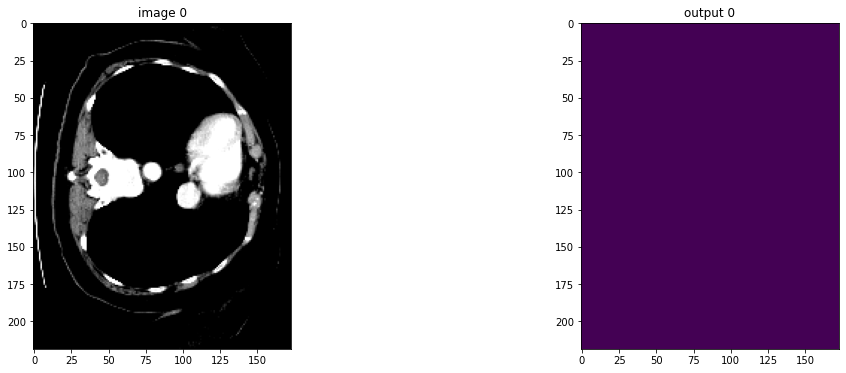

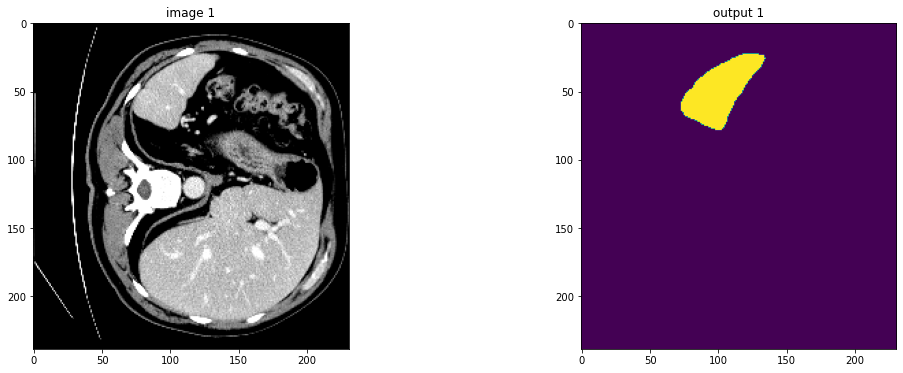

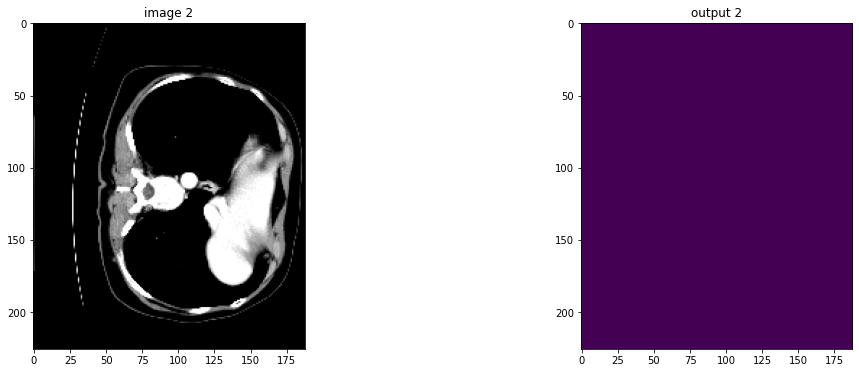

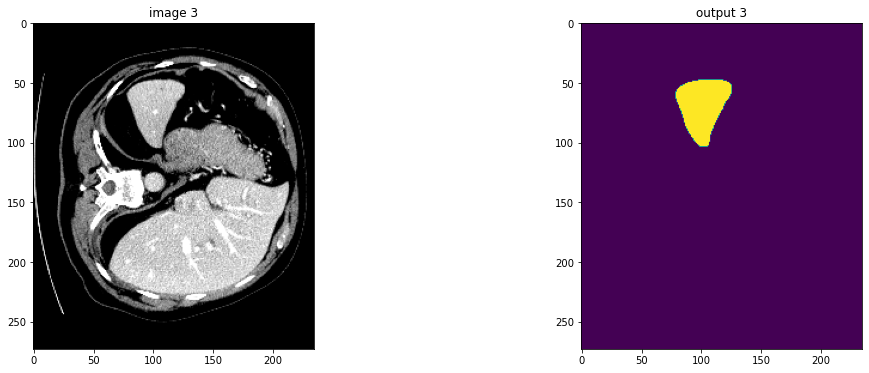

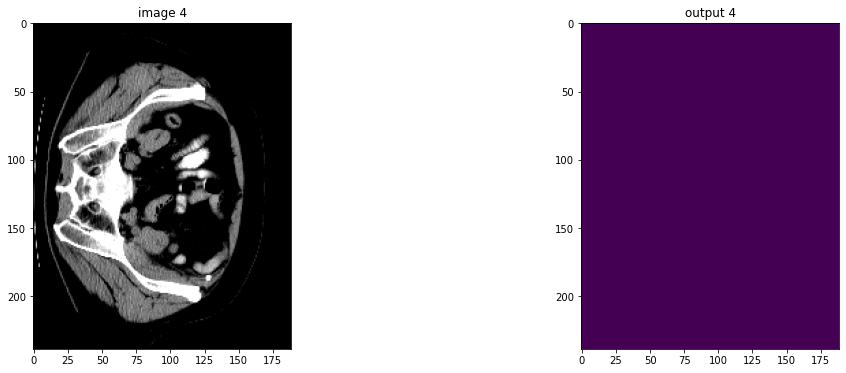

In [429]:
with torch.no_grad():
    j=0
    for i, test_data in enumerate(test_loader):   
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(test_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(predictions[i]["pred"][0])
        j+=1
        if j == end:
            break

        plt.show()

## Clean up the resources

+ delete endpoints to save cost

In [ ]:
#delete current endpoint
predictor.delete_predictor(delete_endpoint_config=True)

In [ ]:
#delete all the endpoints to save cost
import boto3
client = boto3.client('sagemaker')
endpoints=client.list_endpoints()['Endpoints']
for endpoint in endpoints:
    response = client.delete_endpoint(
        EndpointName=endpoint['EndpointName']
    )